## Data Splitting

In [1]:
from torchvision import transforms
from torch import tensor
import os
import myutils

## Defining Dataset

In [2]:
from torch.utils.data import Dataset, DataLoader, Subset
from os import path
from glob import glob
from PIL import Image
import torch
import numpy as np
import random
# np.random.seed(2020)
# random.seed(2020)
# torch.manual_seed(2020)

class VideoDataset(Dataset):
    def __init__(self, ds_path, frame_transform, video_transform, num_frames: int = 16):
        self.frame_transform = frame_transform
        self.video_transform = video_transform
        self.ds_path = ds_path
        self.ids = glob(path.join(self.ds_path, '*'))
        self.labels = [i for i in range(len(self.ids))]
        self.num_frames = num_frames
        
    def __len__(self):
        return len(self.ids)
    
    def __getitem__(self, idx):
        videos = glob(path.join(self.ids[idx], "*"))
        filtered_videos = []
        for video in videos:
            path2imgs = glob(path.join(video, "*.jpg"))
            if len(path2imgs) >= self.num_frames:
                filtered_videos.append(video)
        
        if len(filtered_videos) <= 0:
            return self[(idx+1) % len(self)]
        else:
            chosen_video_index = int(len(filtered_videos) * np.random.uniform())

            path2imgs = glob(path.join(filtered_videos[chosen_video_index], "*.jpg"))
            start_idx = int((len(path2imgs) - self.num_frames) * np.random.uniform())
            path2imgs = path2imgs[start_idx : start_idx + self.num_frames]
            if self.num_frames > len(path2imgs):
                print(len(path2imgs))
                print(videos[chosen_video_index])
            label = self.labels[idx]
            frames = []

            for p2i in path2imgs:
                frame = Image.open(p2i)
                frames.append(frame)
#             seed = np.random.randint(1e9)
            frames_tr = []
            for frame in frames:
                frame = self.frame_transform(frame)
                frames_tr.append(frame)
            if len(frames_tr)>0:
                frames_tr = torch.stack(frames_tr)
                frames_tr = self.video_transform(frames_tr)
            return frames_tr, label

In [3]:
# choose one
model_type = "3dcnn"
model_type = "rnn"    

timesteps =30
if model_type == "rnn":
    h, w = 224, 224
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
else:
    h, w = 112, 112
    mean = [0.43216, 0.394666, 0.37645]
    std = [0.22803, 0.22145, 0.216989]

In [4]:
import torchvision.transforms as transforms

train_frame_transformer = transforms.Compose([
            transforms.Resize((256,256)),
            transforms.ToTensor(),
            transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])])
train_video_transformer = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
#             transforms.RandomAffine(degrees=0, translate=(0.1,0.1)),
            transforms.RandomCrop([224,224])])

train_ds = VideoDataset('/home/ssd_storage/datasets/youtube_faces/aligned_images_DB_MTCNN', train_frame_transformer, train_video_transformer)
print(len(train_ds))


1595


In [5]:
train_ds = VideoDataset('/home/ssd_storage/datasets/youtube_faces/aligned_images_DB_MTCNN', train_frame_transformer, train_video_transformer)
print(len(train_ds))

1595


In [6]:
test_frame_transformer = transforms.Compose([
            transforms.Resize((256,256)),
            transforms.ToTensor(),
            transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])])
test_video_transformer = transforms.Compose([
            transforms.CenterCrop([224,224])])

test_ds = VideoDataset('/home/ssd_storage/datasets/youtube_faces/aligned_images_DB_MTCNN', test_frame_transformer, test_video_transformer)
print(len(test_ds))

1595


## Defining Data Loaders

In [7]:
def collate_fn_r3d_18(batch):
    imgs_batch, label_batch = list(zip(*batch))
    imgs_batch = [imgs for imgs in imgs_batch if len(imgs)>0]
    label_batch = [torch.tensor(l) for l, imgs in zip(label_batch, imgs_batch) if len(imgs)>0]
    imgs_tensor = torch.stack(imgs_batch)
    imgs_tensor = torch.transpose(imgs_tensor, 2, 1)
    labels_tensor = torch.stack(label_batch)
    return imgs_tensor,labels_tensor

def collate_fn_rnn(batch):
    imgs_batch, label_batch = list(zip(*batch))
    imgs_batch = [imgs for imgs in imgs_batch if len(imgs)>0]
    label_batch = [torch.tensor(l) for l, imgs in zip(label_batch, imgs_batch) if len(imgs)>0]
    imgs_tensor = torch.stack(imgs_batch)
    labels_tensor = torch.stack(label_batch)
    return imgs_tensor,labels_tensor
    

batch_size = 8
if model_type == "rnn":
    train_dl = DataLoader(train_ds, batch_size= batch_size,
                          shuffle=True, collate_fn=collate_fn_rnn)
    test_dl = DataLoader(test_ds, batch_size= 2*batch_size,
                         shuffle=False, collate_fn=collate_fn_rnn)  
else:
    train_dl = DataLoader(train_ds, batch_size= batch_size, 
                          shuffle=True, collate_fn=collate_fn_r3d_18)
    test_dl = DataLoader(test_ds, batch_size= 2*batch_size, 
                         shuffle=False, collate_fn= collate_fn_r3d_18)          

In [8]:
for xb,yb in train_dl:
    print(xb.shape, yb.shape)
    break

torch.Size([8, 16, 3, 224, 224]) torch.Size([8])


In [9]:
for xb,yb in test_dl:
    print(xb.shape, yb.shape)
    break

torch.Size([16, 16, 3, 224, 224]) torch.Size([16])


## Defining Model

In [10]:
from torch import nn
class Vgg16Rnn(nn.Module):
    def __init__(self, params_model):
        super(Vgg16Rnn, self).__init__()
        num_classes = params_model["num_classes"]
        dr_rate= params_model["dr_rate"]
        pretrained = params_model["pretrained"]
        rnn_hidden_size = params_model["rnn_hidden_size"]
        rnn_num_layers = params_model["rnn_num_layers"]
        self.train_seq = params_model["train_seq"]
        
        baseModel = models.vgg16(pretrained=pretrained)
        num_features = baseModel.classifier[-1].in_features
        del baseModel.classifier[-1]
        self.baseModel = baseModel
        self.dropout= nn.Dropout(dr_rate)
        self.rnn = nn.GRU(num_features, rnn_hidden_size, rnn_num_layers) #LSTM
        self.classifier = nn.Linear(rnn_hidden_size, num_classes)
    
    def frame_forward(self, x, h=None, c=None):
        batch_size, channels, height, width = x.shape
        cnn_features = self.baseModel((x))
        if (h is None) and (c is None):
            out, (hn, cn) = self.rnn(cnn_features.unsqueeze(1))
        else:
            out, (hn, cn) = self.rnn(cnn_features.unsqueeze(1), (h, c))
        out = self.dropout(out[:,-1])
        out = self.classifier(out)
        return out, hn, cn
    
    def seq_forward(self, x):
        batch_size, time_series, channels, height, width = x.shape
        if time_series < 16:
            print(x.shape)
        frame_idx = 0
        cnn_features = self.baseModel((x[:,frame_idx]))
        out, (hn, cn) = self.rnn(cnn_features.unsqueeze(1))
        for frame_idx in range(1, time_series):
            y = self.baseModel((x[:,frame_idx]))
            out, (hn, cn) = self.rnn(y.unsqueeze(1), (hn, cn))
        out = self.dropout(out[:,-1])
        out = self.classifier(out) 
        return out
    
    def forward(self, x, h=None, c=None):
        if self.train_seq:
            return self.seq_forward(x)
        else:
            return self.frame_forward(x, h, c)
    
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x    

In [11]:
from torch import nn
class Vgg16Rnn(nn.Module):
    def __init__(self, params_model):
        super(Vgg16Rnn, self).__init__()
        num_classes = params_model["num_classes"]
        dr_rate= params_model["dr_rate"]
        pretrained = params_model["pretrained"]
        rnn_hidden_size = params_model["rnn_hidden_size"]
        rnn_num_layers = params_model["rnn_num_layers"]
        self.train_seq = params_model["train_seq"]
        
        baseModel = models.vgg16(pretrained=pretrained)
        num_features = baseModel.classifier[-1].in_features
        del baseModel.classifier[-1]
        self.baseModel = baseModel
        self.dropout= nn.Dropout(dr_rate)
        self.rnn = nn.RNNCell(num_features, rnn_hidden_size) #LSTM
        self.classifier = nn.Linear(rnn_hidden_size, num_classes) # rnn_hidden_size
    
    def frame_forward(self, x, h=None, c=None):
        batch_size, channels, height, width = x.shape
        cnn_features = self.baseModel((x))
#         hx = cnn_features
#         cx = None
        if (h is None) and (c is None):
            hx = self.rnn(cnn_features)
        else:
            hx = self.rnn(cnn_features, h)
        hx = self.dropout(hx)
        out = self.classifier(hx)
        return out, hx, None
    
    def seq_forward(self, x):
        raise NotImplemented
    
    def forward(self, x, h=None, c=None):
        if self.train_seq:
            return self.seq_forward(x)
        else:
            return self.frame_forward(x, h, c)
    
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x    

In [12]:
from torch import nn
class Vgg16Decoder(nn.Module):
    def __init__(self, params_model):
        super(Vgg16Decoder, self).__init__()
        num_classes = params_model["num_classes"]
        dr_rate= params_model["dr_rate"]
        pretrained = params_model["pretrained"]
        rnn_hidden_size = params_model["rnn_hidden_size"]
        rnn_num_layers = params_model["rnn_num_layers"]
        self.train_seq = params_model["train_seq"]
        
#         baseModel = models.vgg16(pretrained=pretrained)
        #Using pretrained facenet
        if pretrained:
            baseModel = models.vgg16(num_classes=8749)
            baseModel.features = torch.nn.DataParallel(baseModel.features)
            model_checkpoint = torch.load('/home/administrator/experiments/familiarity/pretraining/vgg16/models/119.pth')
            baseModel.load_state_dict(model_checkpoint['state_dict'])

            for param in baseModel.parameters():
                param.requires_grad = False
        else:
            baseModel = models.vgg16()
        
        num_features = baseModel.classifier[-1].in_features
        del baseModel.classifier[-1]
        self.baseModel = baseModel
        self.dropout= nn.Dropout(dr_rate)
        self.linear = nn.Linear(num_features, rnn_hidden_size)
        decoder_layer = nn.TransformerDecoderLayer(d_model=rnn_hidden_size, nhead=8)
        transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=rnn_num_layers)
        self.decoder = transformer_decoder
        self.classifier = nn.Linear(rnn_hidden_size, num_classes) # rnn_hidden_size
    
    def frame_forward(self, x, h=None, c=None):
        raise NotImplemented
    
    def seq_forward(self, x):
        bs, ts, c, h, w = x.shape
        frame_features = []
        for t in range(ts):
            features = self.baseModel(x[:, t])
            projected = self.linear(features)
            frame_features.append(projected)
        frame_features = torch.stack(frame_features, dim=1)
        transformed = self.decoder(frame_features, frame_features)
        return self.classifier(transformed[:, -1])
    
    def forward(self, x, h=None, c=None):
        if self.train_seq:
            return self.seq_forward(x)
        else:
            return self.frame_forward(x, h, c)
    
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x    
    

In [13]:
from torchvision import models
from torch import nn

# if model_type == "rnn":
params_model={
    "num_classes": len(train_ds),
    "dr_rate": 0.0001,
    "pretrained" : False,
    "rnn_num_layers": 2,
    "rnn_hidden_size": 512, 'train_seq': True}
model = Vgg16Decoder(params_model)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
# else:
#     model = models.video.r3d_18(pretrained=True, progress=False)
#     num_features = model.fc.in_features
#     model.fc = nn.Linear(num_features, num_classes)

path2weights = "./models/weights.pt"
os.makedirs("./models", exist_ok=True)
torch.save(model.state_dict(), path2weights)

## Training Model

In [14]:
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau

loss_func = nn.CrossEntropyLoss()#reduction="sum"
opt = optim.Adam(model.parameters(), lr=1e-5)
# opt = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=50,verbose=1)
os.makedirs("./models", exist_ok=True)

params_train={
    "num_epochs": 200,
    "optimizer": opt,
    "loss_func": loss_func,
    "train_dl": train_dl,
    "val_dl": test_dl,
    "sanity_check": False,
    "lr_scheduler": lr_scheduler,
    "path2weights": "./models/weights_"+model_type+".pt", 'train_seq': True,
    }
model,loss_hist,metric_hist = myutils.train_val(model,params_train)

Epoch 0/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.969605, dev loss: 0.469888, accuracy: 0.06
----------
Epoch 1/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.953313, dev loss: 0.468019, accuracy: 0.13
----------
Epoch 2/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.946776, dev loss: 0.466824, accuracy: 0.13
----------
Epoch 3/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.943102, dev loss: 0.465978, accuracy: 0.13
----------
Epoch 4/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.941570, dev loss: 0.465379, accuracy: 0.13
----------
Epoch 5/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.940082, dev loss: 0.464981, accuracy: 0.13
----------
Epoch 6/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.938691, dev loss: 0.464528, accuracy: 0.13
----------
Epoch 7/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.937935, dev loss: 0.464196, accuracy: 0.13
----------
Epoch 8/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.936311, dev loss: 0.463871, accuracy: 0.13
----------
Epoch 9/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.935992, dev loss: 0.463606, accuracy: 0.13
----------
Epoch 10/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.936060, dev loss: 0.463217, accuracy: 0.13
----------
Epoch 11/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.934438, dev loss: 0.462992, accuracy: 0.25
----------
Epoch 12/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.934049, dev loss: 0.462632, accuracy: 0.25
----------
Epoch 13/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.933576, dev loss: 0.462120, accuracy: 0.25
----------
Epoch 14/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.932732, dev loss: 0.461732, accuracy: 0.25
----------
Epoch 15/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.931985, dev loss: 0.461258, accuracy: 0.13
----------
Epoch 16/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.930179, dev loss: 0.460797, accuracy: 0.19
----------
Epoch 17/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.930039, dev loss: 0.460094, accuracy: 0.13
----------
Epoch 18/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.928185, dev loss: 0.458513, accuracy: 0.13
----------
Epoch 19/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.928210, dev loss: 0.457652, accuracy: 0.19
----------
Epoch 20/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.924222, dev loss: 0.455889, accuracy: 0.13
----------
Epoch 21/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.921997, dev loss: 0.454731, accuracy: 0.31
----------
Epoch 22/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.918557, dev loss: 0.452642, accuracy: 0.06
----------
Epoch 23/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.916143, dev loss: 0.450908, accuracy: 0.13
----------
Epoch 24/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.911429, dev loss: 0.448540, accuracy: 0.25
----------
Epoch 25/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.908876, dev loss: 0.446093, accuracy: 0.31
----------
Epoch 26/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.905947, dev loss: 0.443778, accuracy: 0.31
----------
Epoch 27/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.902505, dev loss: 0.441596, accuracy: 0.69
----------
Epoch 28/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.894565, dev loss: 0.438111, accuracy: 0.44
----------
Epoch 29/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.892229, dev loss: 0.435500, accuracy: 0.69
----------
Epoch 30/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.887163, dev loss: 0.432948, accuracy: 0.69
----------
Epoch 31/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.885747, dev loss: 0.431103, accuracy: 1.07
----------
Epoch 32/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.882205, dev loss: 0.428311, accuracy: 1.13
----------
Epoch 33/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.876827, dev loss: 0.426483, accuracy: 1.25
----------
Epoch 34/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.872851, dev loss: 0.424785, accuracy: 1.25
----------
Epoch 35/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.871183, dev loss: 0.422537, accuracy: 1.50
----------
Epoch 36/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.864020, dev loss: 0.420847, accuracy: 2.07
----------
Epoch 37/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.863428, dev loss: 0.419154, accuracy: 2.38
----------
Epoch 38/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.858290, dev loss: 0.417879, accuracy: 2.63
----------
Epoch 39/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.856811, dev loss: 0.416364, accuracy: 2.63
----------
Epoch 40/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.853257, dev loss: 0.414295, accuracy: 2.76
----------
Epoch 41/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.849066, dev loss: 0.412449, accuracy: 3.45
----------
Epoch 42/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.846446, dev loss: 0.411270, accuracy: 3.45
----------
Epoch 43/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.845301, dev loss: 0.408875, accuracy: 4.14
----------
Epoch 44/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.839917, dev loss: 0.408072, accuracy: 3.45
----------
Epoch 45/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.836714, dev loss: 0.407494, accuracy: 3.39
----------
Epoch 46/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.834220, dev loss: 0.403140, accuracy: 4.20
----------
Epoch 47/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.830808, dev loss: 0.401944, accuracy: 4.14
----------
Epoch 48/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.829859, dev loss: 0.400430, accuracy: 4.83
----------
Epoch 49/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.824748, dev loss: 0.398323, accuracy: 5.45
----------
Epoch 50/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.822461, dev loss: 0.395446, accuracy: 6.58
----------
Epoch 51/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.822908, dev loss: 0.394242, accuracy: 6.65
----------
Epoch 52/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.817094, dev loss: 0.392094, accuracy: 6.33
----------
Epoch 53/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.811540, dev loss: 0.390359, accuracy: 7.34
----------
Epoch 54/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.809253, dev loss: 0.389070, accuracy: 7.71
----------
Epoch 55/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.806805, dev loss: 0.387139, accuracy: 8.90
----------
Epoch 56/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.803623, dev loss: 0.385219, accuracy: 8.46
----------
Epoch 57/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.797249, dev loss: 0.382852, accuracy: 9.40
----------
Epoch 58/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.797640, dev loss: 0.381178, accuracy: 10.16
----------
Epoch 59/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.792262, dev loss: 0.379649, accuracy: 10.03
----------
Epoch 60/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.791580, dev loss: 0.377104, accuracy: 11.29
----------
Epoch 61/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.787503, dev loss: 0.376884, accuracy: 11.66
----------
Epoch 62/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.782991, dev loss: 0.373351, accuracy: 12.23
----------
Epoch 63/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.779221, dev loss: 0.371788, accuracy: 11.72
----------
Epoch 64/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.778307, dev loss: 0.369780, accuracy: 13.04
----------
Epoch 65/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.775124, dev loss: 0.368307, accuracy: 12.60
----------
Epoch 66/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

train loss: 0.773354, dev loss: 0.368441, accuracy: 13.98
----------
Epoch 67/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.768084, dev loss: 0.365100, accuracy: 14.04
----------
Epoch 68/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.767716, dev loss: 0.363779, accuracy: 14.86
----------
Epoch 69/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.760638, dev loss: 0.360088, accuracy: 16.68
----------
Epoch 70/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.759828, dev loss: 0.358508, accuracy: 16.18
----------
Epoch 71/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.753562, dev loss: 0.357108, accuracy: 17.68
----------
Epoch 72/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.754251, dev loss: 0.356755, accuracy: 17.18
----------
Epoch 73/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.750663, dev loss: 0.352700, accuracy: 19.12
----------
Epoch 74/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

train loss: 0.746647, dev loss: 0.353260, accuracy: 17.81
----------
Epoch 75/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.740214, dev loss: 0.349873, accuracy: 19.12
----------
Epoch 76/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.737973, dev loss: 0.346906, accuracy: 21.07
----------
Epoch 77/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.738014, dev loss: 0.344426, accuracy: 21.25
----------
Epoch 78/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

train loss: 0.734775, dev loss: 0.344748, accuracy: 20.38
----------
Epoch 79/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.732260, dev loss: 0.342411, accuracy: 21.76
----------
Epoch 80/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.729164, dev loss: 0.339301, accuracy: 22.45
----------
Epoch 81/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.725565, dev loss: 0.338720, accuracy: 22.70
----------
Epoch 82/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.722660, dev loss: 0.336495, accuracy: 23.20
----------
Epoch 83/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.719764, dev loss: 0.333238, accuracy: 23.89
----------
Epoch 84/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.711698, dev loss: 0.330130, accuracy: 25.02
----------
Epoch 85/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

train loss: 0.713160, dev loss: 0.331283, accuracy: 25.27
----------
Epoch 86/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.708208, dev loss: 0.327986, accuracy: 24.95
----------
Epoch 87/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.705246, dev loss: 0.324815, accuracy: 26.39
----------
Epoch 88/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.704192, dev loss: 0.322601, accuracy: 27.65
----------
Epoch 89/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.699112, dev loss: 0.320803, accuracy: 27.15
----------
Epoch 90/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.698316, dev loss: 0.320018, accuracy: 27.71
----------
Epoch 91/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.693185, dev loss: 0.317420, accuracy: 27.71
----------
Epoch 92/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.689185, dev loss: 0.317351, accuracy: 28.34
----------
Epoch 93/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.686856, dev loss: 0.315304, accuracy: 29.03
----------
Epoch 94/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.682662, dev loss: 0.309866, accuracy: 30.97
----------
Epoch 95/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

train loss: 0.679073, dev loss: 0.310188, accuracy: 30.53
----------
Epoch 96/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.674517, dev loss: 0.308889, accuracy: 30.85
----------
Epoch 97/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.671981, dev loss: 0.307797, accuracy: 31.54
----------
Epoch 98/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.671631, dev loss: 0.305882, accuracy: 32.35
----------
Epoch 99/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.669809, dev loss: 0.302089, accuracy: 32.54
----------
Epoch 100/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.664198, dev loss: 0.301819, accuracy: 33.04
----------
Epoch 101/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.658668, dev loss: 0.298590, accuracy: 33.04
----------
Epoch 102/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.659035, dev loss: 0.297683, accuracy: 33.42
----------
Epoch 103/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.655361, dev loss: 0.295506, accuracy: 33.42
----------
Epoch 104/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.650356, dev loss: 0.294799, accuracy: 34.36
----------
Epoch 105/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.646863, dev loss: 0.290716, accuracy: 36.11
----------
Epoch 106/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.645272, dev loss: 0.289502, accuracy: 35.42
----------
Epoch 107/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.641571, dev loss: 0.286363, accuracy: 34.80
----------
Epoch 108/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.638901, dev loss: 0.285591, accuracy: 36.18
----------
Epoch 109/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.634079, dev loss: 0.283990, accuracy: 37.12
----------
Epoch 110/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.634709, dev loss: 0.283361, accuracy: 35.67
----------
Epoch 111/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.627285, dev loss: 0.279755, accuracy: 36.99
----------
Epoch 112/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.623680, dev loss: 0.277941, accuracy: 38.50
----------
Epoch 113/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

train loss: 0.625337, dev loss: 0.277962, accuracy: 36.74
----------
Epoch 114/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.619736, dev loss: 0.272804, accuracy: 37.62
----------
Epoch 115/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.615990, dev loss: 0.271458, accuracy: 38.68
----------
Epoch 116/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

train loss: 0.616333, dev loss: 0.273673, accuracy: 37.18
----------
Epoch 117/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.610604, dev loss: 0.267574, accuracy: 39.87
----------
Epoch 118/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.607163, dev loss: 0.265752, accuracy: 39.25
----------
Epoch 119/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.606762, dev loss: 0.264925, accuracy: 39.50
----------
Epoch 120/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.598261, dev loss: 0.264014, accuracy: 39.50
----------
Epoch 121/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.597587, dev loss: 0.260114, accuracy: 40.06
----------
Epoch 122/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.594143, dev loss: 0.259382, accuracy: 40.63
----------
Epoch 123/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.591861, dev loss: 0.257684, accuracy: 39.81
----------
Epoch 124/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.592683, dev loss: 0.254536, accuracy: 40.63
----------
Epoch 125/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

train loss: 0.583710, dev loss: 0.255181, accuracy: 40.13
----------
Epoch 126/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.581851, dev loss: 0.253216, accuracy: 41.82
----------
Epoch 127/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.579373, dev loss: 0.247130, accuracy: 41.63
----------
Epoch 128/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

train loss: 0.577204, dev loss: 0.248751, accuracy: 41.76
----------
Epoch 129/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.571463, dev loss: 0.246177, accuracy: 41.44
----------
Epoch 130/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.568947, dev loss: 0.244709, accuracy: 41.57
----------
Epoch 131/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.569425, dev loss: 0.242299, accuracy: 43.95
----------
Epoch 132/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.568074, dev loss: 0.238082, accuracy: 44.33
----------
Epoch 133/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

train loss: 0.558170, dev loss: 0.238451, accuracy: 43.07
----------
Epoch 134/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.557262, dev loss: 0.236778, accuracy: 44.26
----------
Epoch 135/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.556437, dev loss: 0.234363, accuracy: 45.52
----------
Epoch 136/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

train loss: 0.553948, dev loss: 0.234449, accuracy: 43.51
----------
Epoch 137/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

train loss: 0.546774, dev loss: 0.234452, accuracy: 43.26
----------
Epoch 138/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.545055, dev loss: 0.229354, accuracy: 44.95
----------
Epoch 139/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.542081, dev loss: 0.227353, accuracy: 45.83
----------
Epoch 140/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.537814, dev loss: 0.223682, accuracy: 45.64
----------
Epoch 141/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

train loss: 0.533709, dev loss: 0.224175, accuracy: 46.08
----------
Epoch 142/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.532490, dev loss: 0.221487, accuracy: 46.96
----------
Epoch 143/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.530252, dev loss: 0.218079, accuracy: 47.40
----------
Epoch 144/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

train loss: 0.527268, dev loss: 0.219421, accuracy: 46.14
----------
Epoch 145/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.520571, dev loss: 0.215856, accuracy: 47.27
----------
Epoch 146/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.522929, dev loss: 0.212531, accuracy: 46.71
----------
Epoch 147/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.520226, dev loss: 0.212066, accuracy: 48.34
----------
Epoch 148/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.513954, dev loss: 0.212014, accuracy: 48.59
----------
Epoch 149/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.511930, dev loss: 0.209970, accuracy: 47.46
----------
Epoch 150/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.512730, dev loss: 0.206429, accuracy: 49.03
----------
Epoch 151/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

train loss: 0.507653, dev loss: 0.208062, accuracy: 47.96
----------
Epoch 152/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.506372, dev loss: 0.205106, accuracy: 49.53
----------
Epoch 153/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.499921, dev loss: 0.202947, accuracy: 49.84
----------
Epoch 154/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.497162, dev loss: 0.201118, accuracy: 49.72
----------
Epoch 155/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.491419, dev loss: 0.198779, accuracy: 49.66
----------
Epoch 156/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

train loss: 0.488732, dev loss: 0.200088, accuracy: 49.22
----------
Epoch 157/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.484405, dev loss: 0.195819, accuracy: 51.54
----------
Epoch 158/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.487211, dev loss: 0.194596, accuracy: 51.10
----------
Epoch 159/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.479036, dev loss: 0.193323, accuracy: 52.85
----------
Epoch 160/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.479800, dev loss: 0.190433, accuracy: 52.23
----------
Epoch 161/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

train loss: 0.474016, dev loss: 0.191090, accuracy: 52.73
----------
Epoch 162/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.471389, dev loss: 0.187144, accuracy: 53.10
----------
Epoch 163/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.470130, dev loss: 0.187132, accuracy: 51.79
----------
Epoch 164/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.462542, dev loss: 0.184046, accuracy: 53.04
----------
Epoch 165/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.456199, dev loss: 0.183274, accuracy: 54.11
----------
Epoch 166/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.464142, dev loss: 0.183263, accuracy: 54.73
----------
Epoch 167/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.456932, dev loss: 0.181361, accuracy: 54.29
----------
Epoch 168/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.452987, dev loss: 0.178707, accuracy: 54.42
----------
Epoch 169/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.452781, dev loss: 0.176130, accuracy: 55.30
----------
Epoch 170/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.448913, dev loss: 0.173973, accuracy: 56.18
----------
Epoch 171/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

train loss: 0.445432, dev loss: 0.175428, accuracy: 54.61
----------
Epoch 172/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.439262, dev loss: 0.172579, accuracy: 55.74
----------
Epoch 173/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.445300, dev loss: 0.169514, accuracy: 57.05
----------
Epoch 174/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.437441, dev loss: 0.167992, accuracy: 57.05
----------
Epoch 175/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.435215, dev loss: 0.164175, accuracy: 59.00
----------
Epoch 176/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

train loss: 0.429024, dev loss: 0.166031, accuracy: 56.99
----------
Epoch 177/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

train loss: 0.426692, dev loss: 0.164819, accuracy: 58.43
----------
Epoch 178/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.422178, dev loss: 0.160984, accuracy: 58.93
----------
Epoch 179/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

train loss: 0.420783, dev loss: 0.163412, accuracy: 57.81
----------
Epoch 180/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.419027, dev loss: 0.159086, accuracy: 58.12
----------
Epoch 181/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.416504, dev loss: 0.158352, accuracy: 58.43
----------
Epoch 182/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.413112, dev loss: 0.156120, accuracy: 58.93
----------
Epoch 183/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.409139, dev loss: 0.154765, accuracy: 60.69
----------
Epoch 184/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.406787, dev loss: 0.153489, accuracy: 60.38
----------
Epoch 185/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.404472, dev loss: 0.150469, accuracy: 60.50
----------
Epoch 186/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

train loss: 0.400151, dev loss: 0.151853, accuracy: 59.37
----------
Epoch 187/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.397120, dev loss: 0.148766, accuracy: 60.19
----------
Epoch 188/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.399284, dev loss: 0.148027, accuracy: 61.38
----------
Epoch 189/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.393503, dev loss: 0.146992, accuracy: 61.25
----------
Epoch 190/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.388409, dev loss: 0.144397, accuracy: 62.19
----------
Epoch 191/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

train loss: 0.385672, dev loss: 0.144522, accuracy: 62.88
----------
Epoch 192/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.384406, dev loss: 0.142440, accuracy: 62.45
----------
Epoch 193/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.382411, dev loss: 0.138126, accuracy: 64.33
----------
Epoch 194/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.386100, dev loss: 0.137365, accuracy: 63.45
----------
Epoch 195/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

train loss: 0.381853, dev loss: 0.140221, accuracy: 63.51
----------
Epoch 196/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.375508, dev loss: 0.134843, accuracy: 64.58
----------
Epoch 197/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

train loss: 0.369399, dev loss: 0.135731, accuracy: 65.27
----------
Epoch 198/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.369997, dev loss: 0.133049, accuracy: 64.64
----------
Epoch 199/199, current lr=1e-05


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

train loss: 0.364861, dev loss: 0.133195, accuracy: 64.51
----------


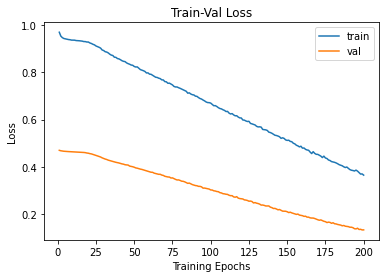

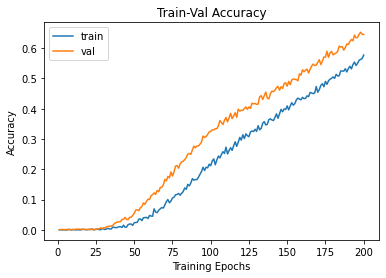

In [15]:
myutils.plot_loss(loss_hist, metric_hist)